# Do some uniform sampling

In [2]:
import numpy as np
import pandas as pd

In [3]:
pheno_path = '/data1/abide/Pheno/pheno.csv'
pheno = pd.read_csv(pheno_path)
age_min = np.min(pheno['AGE_AT_SCAN'].values)
age_max = np.max(pheno['AGE_AT_SCAN'].values)
site_list = [list(pheno.loc[pheno['SITE_ID'] == val]['AGE_AT_SCAN'].values) for val in pheno['SITE_ID'].unique()]
max_range = age_max - age_min

In [4]:
def find_subs(site_list, age_min, age_max, age_range, n_bins, range_steps=40):
    """
    Finds the optimal starting age to maximize the
    sample size while keeping contributions from
    each site (lists in site_list) equal
    """
    # Find the size of the bins for the given range
    bin_size = age_range/float(n_bins)
    # Find the number of sites
    n_sites = len(site_list)
    # Find the step size for the linear sequences
    step_size = ((age_max-age_min)-age_range)/float(range_steps)
    # Make a list of starting indices based on the age steps
    start_range = np.arange(age_min, step_size*range_steps+age_min, step_size)
    stop_range = np.arange(age_min+age_range, age_max, step_size)

    # Prepare the storage variable for the ranges
    range_dict = dict()

    # Now we have a number of range windows that we have to separate into n_bins
    # and find the number of subjects that fit in there
    for r_id in np.arange(range_steps):
        # Set the variables for this range
        r_start = start_range[r_id]
        r_stop = stop_range[r_id]
        start_bin = np.arange(r_start, r_stop, bin_size)
        stop_bin = np.arange(r_start+bin_size, r_stop+bin_size+0.1, bin_size)

        # Temporary storage variable for the sites
        n_subs = np.zeros((n_sites,))
        # Now gothrough all sites and find how many subjects are in the bins
        for site_id, site in enumerate(site_list):
            asite = np.array(site)
            # Find the number of subjects for this site that
            # fit the list of bins
            bin_subs = [np.sum(np.logical_and(asite>=b_start, asite<stop_bin[bin_id])) for bin_id, b_start in enumerate(start_bin)]
            if not bin_subs:
                n_subs[site_id] = 0
                continue
            # Find the smallest number of subjects in any bin for this site
            # and take that times the number of bins
            n_subs[site_id] = np.min(np.array(bin_subs)) * n_bins

        # Check that there is at least one site with non-zero subjects
        if not np.sum(n_subs):
            continue
        # Sort the sites by number of subjects
        sort_ind = np.argsort(n_subs)
        # Optimization criterion
        n_total = 0
        sites = []
        # Go through the sites and drop the ones with low subjects until 
        # the total number is maximal
        for i in np.arange(len(sort_ind)):
            # Slice the sorted index from current position to end
            r_ind = sort_ind[i:]
            # Find the minimal number of subjects in the sites
            min_sub = np.min(n_subs[r_ind])
            tmp = len(r_ind)*min_sub
            if tmp <= n_total and not tmp == 0:
                # We should stop
                sites = r_ind
                break
            else:
                # We should continue
                n_total = tmp
                continue

        # Initialize the range dict
        range_dict[r_id] = {
                           'start_bin': start_bin,
                           'stop_bin': stop_bin,
                           'sites': sites,
                           'num_subs': n_total
                           }

    # Go through all of the ranges again and find the highest total number
    keys = range_dict.keys()
    # Check if there are any sites left
    if not keys:
        start_age = 0
        stop_age = 0
        sites = []
        subjects = 0
    else:
        total_subjects = np.array([range_dict[key]['num_subs'] for key in keys])
        # Find the maximum of total subjects across the ranges
        m_id = np.where(total_subjects==np.max(total_subjects))[0][0]
        r_key = keys[m_id]
        # Get the rest of the config
        start_age = np.min(range_dict[r_key]['start_bin'])
        stop_age = np.max(range_dict[r_key]['stop_bin'])
        sites = range_dict[r_key]['sites']
        subjects = range_dict[r_key]['num_subs']

    return subjects, sites, start_age, stop_age, bin_size

In [24]:
ages = np.linspace(1,max_range,100, endpoint=False)
n_ages = len(ages)
bins = np.arange(2,20)
n_bins = len(bins)

In [36]:
n_sit = np.zeros((n_ages,n_bins))
n_sub = np.zeros((n_ages,n_bins))
res_list = list()
for a_id, age in enumerate(ages):
    res_list.append(list())
    for b_id, bn in enumerate(bins):
        res =  find_subs(site_list, age_min, age_max, age, bn)
        res_list[a_id].append(res)
        n_sit[a_id, b_id] = len(res[1])
        n_sub[a_id, b_id] = res[0]

In [8]:
# Visualize the results
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%pylab inline

Populating the interactive namespace from numpy and matplotlib


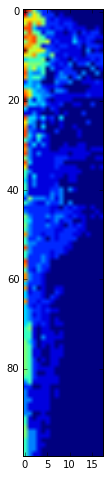

In [87]:
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111)
ax.imshow(n_sit)

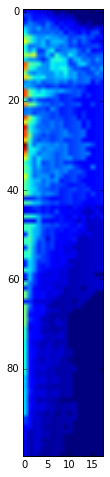

In [88]:
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111)
ax.imshow(n_sub)

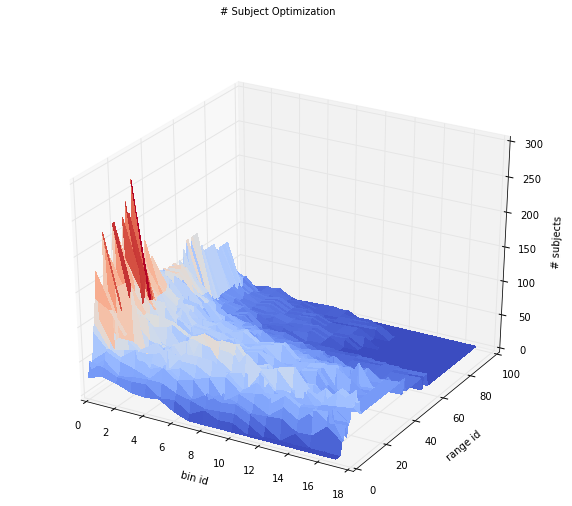

In [29]:
a, b = n_sub.T.shape
X, Y = np.mgrid[:a, :b]

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(1,1,1, projection='3d')
surf = ax.plot_surface(X,Y,n_sub.T,rstride=1, cstride=1, cmap=cm.coolwarm,
        linewidth=0, antialiased=False)
ax.set_xlabel('bin id')
ax.set_ylabel('range id')
ax.set_zlabel('# subjects')
fig.suptitle('# Subject Optimization')

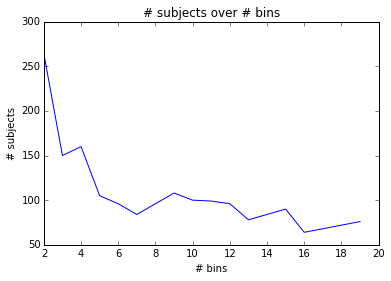

In [31]:
plt.plot(bins,np.max(n_sub, 0))
plt.title('# subjects over # bins')
plt.ylabel('# subjects')
plt.xlabel('# bins')

I'll pull out two different ranges
1. 2 bins to get the maximal number of subjects
2. 4 bins to get a better age distribution

In [78]:
# Find range 1
x1,y1 = np.where(n_sub==np.max(n_sub))
res1 = res_list[x1][y1]
print('Range 1 has {} subjects\n'
     '   sites     : {}\n'
     '   start age : {}\n'
     '   stop age  : {} \n'
     '   bin size  : {} \n'.format(res1[0], len(res1[1]),
                                 res1[2], res1[3], res1[4]))

Range 1 has 264.0 subjects
   sites     : 10
   start age : 6.47
   stop age  : 33.4085 
   bin size  : 8.9795 



In [79]:
# Find range 2
x2 = np.where(n_sub[:,2]==np.max(n_sub[:,2]))[0]
res2 = res_list[x2][2]
print('Range 2 has {} subjects\n'
     '   sites     : {}\n'
     '   start age : {}\n'
     '   stop age  : {} \n'
     '   bin size  : {} \n'.format(res2[0], len(res2[1]),
                                 res2[2], res2[3], res2[4]))

Range 2 has 160.0 subjects
   sites     : 9
   start age : 11.5577
   stop age  : 19.87395 
   bin size  : 1.66325 

